# **Data Cleaning:**
Summarize what we did in Excel, and some stuff moving into python
- dawg i had to manually remove values because 1). the list is so small, 2). not that hard as a result 3). excel/python would take more time
- deleted non 2021-2022 columns 
- In excel, for athabasca, bruderheim,etc. used excel to isolate just unit types, then finished cleaning in pandas

In [2]:
# TODO Determine a town which shows larger decreases in rental rates
# TODO Determine a town which shows larger increases in rental rates (try others)
# TODO Decide whether Raymond is actually necessary or should it just be Athabasca

In [3]:
# further data cleaning in pandas
import pandas as pd
pd.options.mode.chained_assignment = None 

# read datasets
table6 = pd.read_csv("Matthew's Data/Table6.csv")
table8 = pd.read_csv("Matthew's Data/Table8.csv")
table9 = pd.read_csv("Matthew's Data/table9.csv")

# create list of all strings that contain the names of communities in table 8
community_names = table8["Community"].unique().tolist()

# filter the csv based on if it exists in the observed commmunities
table9_byAreaNames = table9[table9["Area Name"].isin(community_names)]

# IMPUTATION WARNING: the only value  
table9_byAreaNames.loc[table9_byAreaNames["Area Name"] == "Grande Cache"] = table9_byAreaNames.loc[table9_byAreaNames["Area Name"] == "Grande Cache"].replace("--", "3276")

# convert 2022 and 2021 column to integer values (since it is currently being read as string)
table9_byAreaNames["2022"] = table9_byAreaNames["2022"].apply(lambda x: int(x))
table9_byAreaNames.drop(["2021"],axis=1,inplace=True)

# display populations (alphabetical order)
table9_cleaned = table9_byAreaNames.sort_values("Area Name")
table9_cleaned
        

,Area Name,Type,2022
308,Athabasca,T,2827
330,Banff,T,9347
296,Barrhead,T,4503
26,Bassano,T,1255
409,Beaverlodge,T,2371
...,...,...,...
183,Vegreville,T,5819
190,Vermilion,T,3978
59,Vulcan,T,1825
131,Wainwright,T,6741


For this data set, it was at some point much easier to clean manually than it was to use excel or python, due to the fact that in this check, less than 15 were absent due to some error, and was as a result, so using ctrl + f and manually editing was not (in general, it isn't a practical solution but here is somehow less time consuming than using python/excel)

New changes
- removed commas in thousands from Table 8 --> can read as numerical values now
- removed "Overall Vacancy Rates" from Table 8, since this is covered in table 6 and is more accurate there, just need the weighted rents between years in table 8\
- added "population" which we want to analyze how town population sizes might also be related to costs and shit
    - add to faceted graph as an outer variable

In [4]:
# remove table8 zeroes (since this is false data)
table8 = table8[table8["2021 Weighted Rent"] != 0]
table8 = table8[table8["2022 Weighted Rent"] != 0]

table8

,Community,Unit Type,2021 Weighted Rent,2022 Weighted Rent
0,Athabasca,1 - Bedroom,840,852
1,Athabasca,2 - Bedroom,912,931
2,Athabasca,3 - Bedroom,1026,980
3,Athabasca,Bachelor,706,719
4,Banff,1 - Bedroom,1318,1435
...,...,...,...,...
247,Wainwright,Bachelor,450,434
248,Westlock,1 - Bedroom,775,768
249,Westlock,2 - Bedroom,881,881
250,Westlock,3 - Bedroom,972,963


In [5]:
atha_vacancies = pd.read_csv("Matthew's Data/Athabasca Summary.csv")
atha_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
atha_vacancies = atha_vacancies.dropna(how='all',axis=1)
atha_vacancies = atha_vacancies.dropna(how='all',axis=0)
atha_vacancies.loc["Percentage"] = atha_vacancies.loc["Percentage"].apply(lambda x: x*100)
atha_vacancies

,Bachelor,1 - Bedroom,2 - Bedroom,3 - Bedroom,4+ Bedroom
Number and Percentage of Vacancies by Type of Unit,,,,,
Number of Units,4.0,45.0,58.0,51.0,0.0
Vacancies,0.0,3.0,9.0,3.0,0.0
Percentage,0.0,6.7,15.5,5.9,0.0


In [6]:
bruderheim_vacancies = pd.read_csv("Matthew's Data/Bruderheim Summary.csv")
bruderheim_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
bruderheim_vacancies = bruderheim_vacancies.dropna(how='all',axis=1)
bruderheim_vacancies = bruderheim_vacancies.dropna(how='all',axis=0)
bruderheim_vacancies.loc["Percentage"] = bruderheim_vacancies.loc["Percentage"].apply(lambda x: x*100)
bruderheim_vacancies

,Bachelor,1 - Bedroom,2 - Bedroom,3 - Bedroom,4+ Bedroom
Number and Percentage of Vacancies by Type of Unit,,,,,
Number of Units,4.0,36.0,36.0,4.0,0.0
Vacancies,2.0,19.0,12.0,3.0,0.0
Percentage,50.0,52.8,33.3,75.0,0.0


-------

# **Visualizations + Analysis:**

Potential Conclusions from these visuals:
- This one is pretty much just number of vacancies relative to the number of units over rental ranges
- Overall, for the most part pretty much mostly, the vacancies tend to be proportional to the number of units in that range

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Divide population into different sizes
population_labels, population_bins = pd.qcut(table9_cleaned["2022"], 3, retbins=True) # 
print("Bin Divisions:",population_bins.astype(int))

Bin Divisions: [  719  2492  5760 14996]


This means we are going to divide the population as:
- Small: [719, 2492]
- Medium: (2492, 5760]
- Large: (5760, 14996]

In [9]:
# list of medium towns (size 2493-5760)
med_towns = table9_cleaned[table9_cleaned["2022"].between(population_bins[1], population_bins[2], inclusive='right')]
med_towns

,Area Name,Type,2022
308,Athabasca,T,2827
296,Barrhead,T,4503
85,Black Diamond,T,2825
29,Cardston,T,3828
96,Carstairs,T,5181
38,Claresholm,T,3957
98,Didsbury,T,5172
425,Fairview,T,2914
36,Fort Macleod,T,3499
402,Grande Cache,T,3276


In [10]:
# list of large towns (size 5760-14996)
big_towns = table9_cleaned[table9_cleaned["2022"].between(population_bins[2], population_bins[3], inclusive='right')]
big_towns

,Area Name,Type,2022
330,Banff,T,9347
150,Blackfalds,T,11363
256,Bonnyville,T,6632
18,Coaldale,T,9179
322,Crowsnest Pass,SM,5910
226,Drayton Valley,T,7482
68,Drumheller,T,8231
320,Edson,T,8399
81,High River,T,14996
319,Hinton,T,9933


In [11]:
# get mean rent by each unit type for both 2021 and 2022
mean_bachelors2022 = table8[table8["Unit Type"] == "Bachelor"]["2022 Weighted Rent"].mean()
mean_1beds2022 = table8[table8["Unit Type"] == "1 - Bedroom"]["2022 Weighted Rent"].mean()
mean_2beds2022 = table8[table8["Unit Type"] == "2 - Bedroom"]["2022 Weighted Rent"].mean()
mean_3beds2022 = table8[table8["Unit Type"] == "3 - Bedroom"]["2022 Weighted Rent"].mean()
mean_4beds2022 = table8[table8["Unit Type"] == "4+ Bedroom"]["2022 Weighted Rent"].mean()

mean_bachelors2021 = table8[table8["Unit Type"] == "Bachelor"]["2021 Weighted Rent"].mean()
mean_1beds2021 = table8[table8["Unit Type"] == "1 - Bedroom"]["2021 Weighted Rent"].mean()
mean_2beds2021 = table8[table8["Unit Type"] == "2 - Bedroom"]["2021 Weighted Rent"].mean()
mean_3beds2021 = table8[table8["Unit Type"] == "3 - Bedroom"]["2021 Weighted Rent"].mean()
mean_4beds2021 = table8[table8["Unit Type"] == "4+ Bedroom"]["2021 Weighted Rent"].mean()

print("2021 Mean Bachelor Rents:",mean_bachelors2021)
print("2021 Mean 1 - Bedroom Rents:",mean_1beds2021)
print("2021 Mean 2 - Bedroom Rents:",mean_2beds2021)
print("2021 Mean 3 - Bedroom Rents:",mean_3beds2021)
print("2021 Mean 4+ Bedroom Rents:",mean_4beds2021)

print()

print("2022 Mean Bachelor Rents:",mean_bachelors2022)
print("2022 Mean 1 - Bedroom Rents:",mean_1beds2022)
print("2022 Mean 2 - Bedroom Rents:",mean_2beds2022)
print("2022 Mean 3 - Bedroom Rents:",mean_3beds2022)
print("2022 Mean 4+ Bedroom Rents:",mean_4beds2022)

2021 Mean Bachelor Rents: 688.741935483871
2021 Mean 1 - Bedroom Rents: 779.925925925926
2021 Mean 2 - Bedroom Rents: 900.6101694915254
2021 Mean 3 - Bedroom Rents: 1036.625
2021 Mean 4+ Bedroom Rents: 1625.0

2022 Mean Bachelor Rents: 702.741935483871
2022 Mean 1 - Bedroom Rents: 826.0
2022 Mean 2 - Bedroom Rents: 943.1186440677966
2022 Mean 3 - Bedroom Rents: 1064.6041666666667
2022 Mean 4+ Bedroom Rents: 1708.6


In [35]:
# list of "small" towns (size 719-2492)
small_towns = table9_cleaned[table9_cleaned["2022"].between(population_bins[0], population_bins[1])]
small_towns

,Area Name,Type,2022
26,Bassano,T,1255
409,Beaverlodge,T,2371
4,Bow Island,T,2129
137,Bowden,T,1297
202,Bruderheim,T,1392
145,Eckville,T,1079
260,Elk Point,T,1455
417,Falher,T,1034
401,Fox Creek,T,1841
48,Hanna,T,2492


In [ ]:
# TASKS FOR FRIDAY:
# TODO plot all of the sampled small towns --> bar graph as well as line graph
# TODO pick 4-5 medium towns and do the same
# TODO pick 4-5 big towns (one of which should include Slave Lake) and do the same

<u>Note</u>:
- Main idea with small towns is smaller rents usually due to smaller populations, so might this affect vacancy rates?
- Usually less housing types or smaller rents noticed compared to average, keep note of this
- Falher and Tofield might be interesting since both have similar trends but Falher has more decrease
- Even if nothing remarkable comes of this, still remark it

In [ ]:
# Sampled Small Towns: Falher, Tofield, Fox Creek, Beaverlodge (excluding bachelor), possibly Mclennan, Millet or Two Hills
smalltowns = ["Beaverlodge", "Fox Creek", "Falher", "Tofield", "Millet", "Two Hills", "Mclennan"]
costs_smalltowns = table8[table8["Community"].isin(smalltowns)]
vacancy_smalltowns = table6[table6["Community"].isin(smalltowns)]

beaver = costs_smalltowns[costs_smalltowns["Community"] == "Beaverlodge"]
foxcreek = costs_smalltowns[costs_smalltowns["Community"] == "Fox Creek"]

beaver_rents = beaver[["2021 Weighted Rent", "2022 Weighted Rent"]]
foxcreek_rents = foxcreek[["2021 Weighted Rent", "2022 Weighted Rent"]]

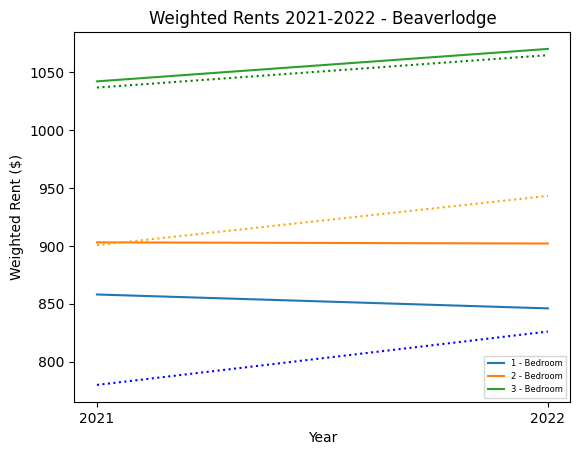

In [54]:
# tester
for i in range(len(beaver.index)):
    plt.plot(["2021", "2022"], beaver_rents.iloc[i], label=beaver["Unit Type"].iloc[i])

plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Beaverlodge") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6})
plt.show()

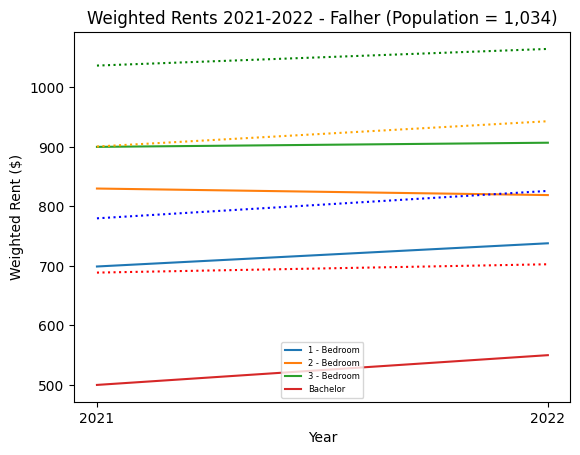

In [39]:
# increaseing, but below average
for i in range(len(foxcreek.index)):
    plt.plot(["2021", "2022"], foxcreek_rents.iloc[i], label=foxcreek["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 - Falher (Population = 1,034)") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6})
plt.show()

---------------------------------

In [26]:
# Sampling
sampletowns = ["Athabasca","Bruderheim","Tofield","Fox Creek"] #
costs_sampletowns = table8[table8["Community"].isin(sampletowns)]
vacancy_sampletowns = table6[table6["Community"].isin(sampletowns)]

atha = costs_sampletowns[costs_sampletowns["Community"] == "Athabasca"]
bruderheim = costs_sampletowns[costs_sampletowns["Community"] == "Bruderheim"]
tofield = costs_sampletowns[costs_sampletowns["Community"] == "Tofield"]
taber = costs_sampletowns[costs_sampletowns["Community"] == "Fox Creek"]

atha_rents = atha[["2021 Weighted Rent", "2022 Weighted Rent"]]
bruderheim_rents = bruderheim[["2021 Weighted Rent", "2022 Weighted Rent"]]
tofield_rents = tofield[["2021 Weighted Rent", "2022 Weighted Rent"]]
taber_rents = taber[["2021 Weighted Rent", "2022 Weighted Rent"]]

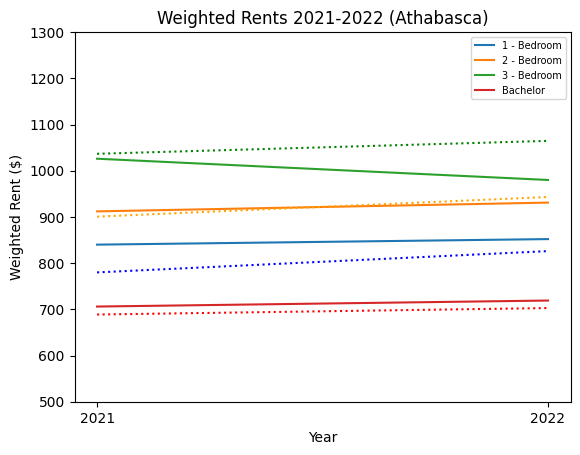

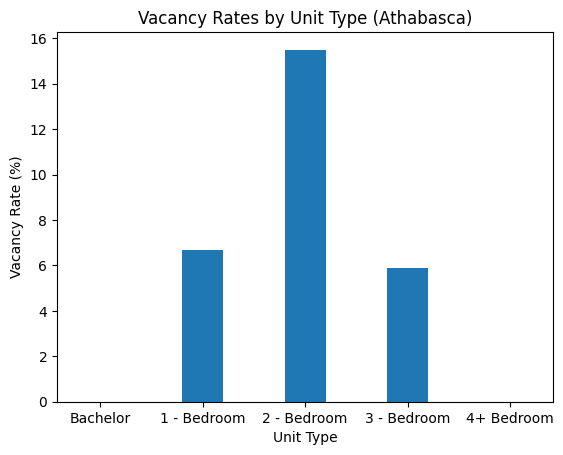

In [15]:
# small change only example (baseline)
for i in range(len(atha.index)):
    plt.plot(["2021", "2022"], atha_rents.iloc[i], label=atha["Unit Type"].iloc[i])

plt.ylim(500, 1300)
plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")

plt.title("Weighted Rents 2021-2022 (Athabasca)") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 7})
plt.show()

# bar graph of individual vacancies:
plt.bar(atha_vacancies.columns, np.array(atha_vacancies.loc["Percentage"]), 0.4)
plt.title("Vacancy Rates by Unit Type (Athabasca)")
plt.xlabel("Unit Type")
plt.ylabel("Vacancy Rate (%)")
plt.show()

<u>Notes</u>:
- This graph has rents close to the average mostly for all units
- 3-bedroom did experience a drop a bit below the average pricing for 3-bedroom rents, the rest are mostly stable
- Vacancy Rate decreased by $6\%$ from $15.5\%$ to $9.5\%$

<br>

- highest is 2bedroom drop
- drop in 3-bedroom might correlate with smaller vacancy rate?

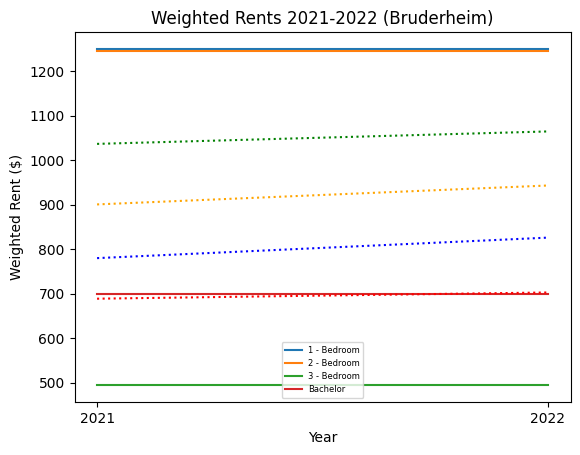

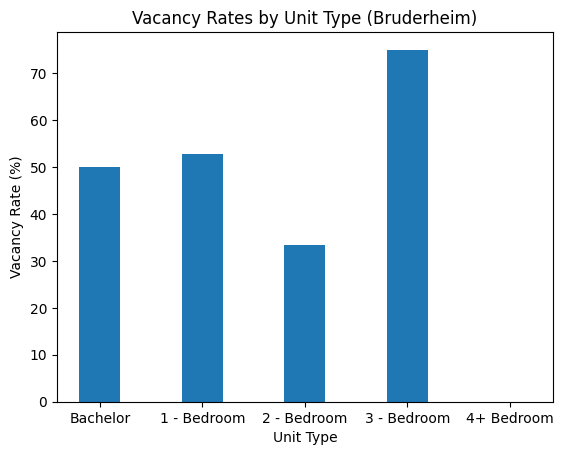

In [16]:
# stable but weird example
for i in range(len(bruderheim.index)):
    plt.plot(["2021", "2022"], bruderheim_rents.iloc[i], label=bruderheim["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 (Bruderheim)") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6})
plt.show()

# bar graph of individual vacancies for Bruderheim
plt.bar(bruderheim_vacancies.columns, np.array(bruderheim_vacancies.loc["Percentage"]), 0.4)
plt.title("Vacancy Rates by Unit Type (Bruderheim)")
plt.xlabel("Unit Type")
plt.ylabel("Vacancy Rate (%)")
plt.show()

<u>Notes</u>:
- All rental prices remained exactly the same for all units in both years
- However, the 1-bed and 2-bed has an average rent of > $1200 significantly higher than 
- 3-bedroom has avg rent of <$500 --> most common type
- Vacancy Rate went up from $38.8\%$ to $45\%$ overall

<br>

- Much higher vacancy rates overall compared to Athabasca
- 

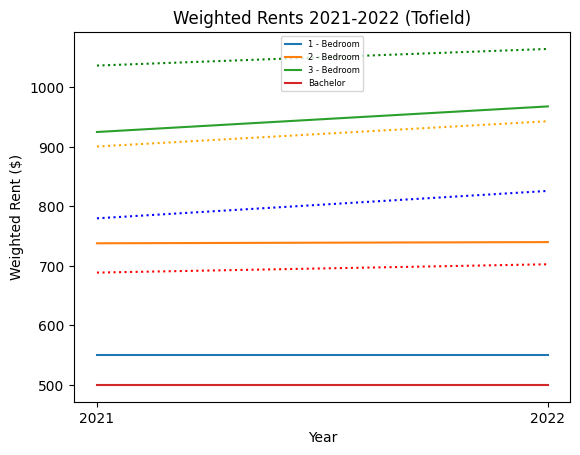

In [17]:
# stable but below average
for i in range(len(tofield.index)):
    plt.plot(["2021", "2022"], tofield_rents.iloc[i], label=tofield["Unit Type"].iloc[i])

plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color="r")
plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
plt.title("Weighted Rents 2021-2022 (Tofield)") 
plt.xlabel("Year")
plt.ylabel("Weighted Rent ($)")
plt.legend(prop={'size': 6})
plt.show()

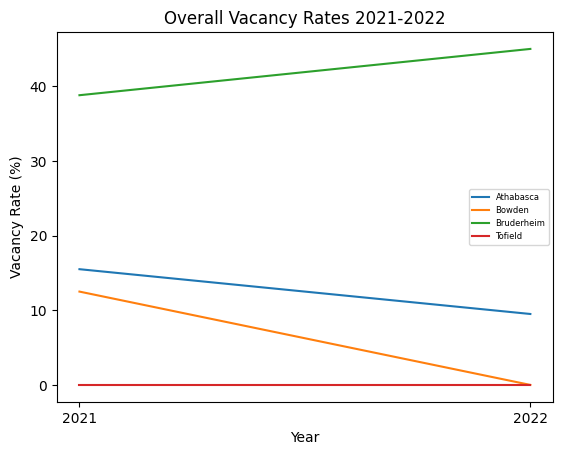

In [18]:
# small town vacancies
vacancy_smalltowns_num = vacancy_sampletowns[["2021 Vacancy", "2022 Vacancy"]]
for i in range(len(vacancy_sampletowns.index)):
    plt.plot(["2021", "2022"], vacancy_smalltowns_num.iloc[i], label=vacancy_sampletowns["Community"].iloc[i])

plt.title("Overall Vacancy Rates 2021-2022") 
plt.xlabel("Year")
plt.ylabel("Vacancy Rate (%)")
plt.legend(prop={'size': 6})
plt.show()